In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, recall_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

In [7]:
icu_data = (
    pd.read_csv("Preprocessed ICU data.csv")
    .rename(columns=lambda col:col.strip())
    .dropna()
)

In [10]:
icu_data

,RecordID,Age,Gender,Height,ICUType2,ICUType3,ICUType4,Mean_Weight.x,Mean_GCS.x,Mean_HR.x,...,Max_ALT.y,Max_AST.y,Max_Bilirubin.y,Max_Lactate.y,Max_Cholesterol.y,Max_TroponinI.y,Max_TroponinT.y,SAPS.I,SOFA,In.hospital_death
0,132543,68,1.0,180.300000,0,1,0,84.600000,14.888889,72.971429,...,12.000000,15.000000,0.200000,2.395461,156.842105,7.132683,1.114629,7,1,0
1,132545,88,0.0,169.787227,0,1,0,83.054136,15.000000,79.520000,...,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629,17,2,0
2,132547,64,1.0,180.300000,0,0,0,114.000000,8.333333,81.318182,...,60.000000,162.000000,0.400000,2.395461,212.000000,1.300000,1.114629,14,11,0
3,132551,78,0.0,162.600000,0,1,0,48.400000,13.250000,78.125000,...,46.000000,82.000000,0.300000,2.300000,156.842105,3.500000,1.114629,19,8,1
4,132554,64,0.0,169.787227,0,1,0,60.700000,15.000000,129.363636,...,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629,11,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,142661,89,1.0,177.800000,0,0,1,64.000000,11.214286,86.260870,...,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629,6,4,0
1470,142662,86,1.0,162.600000,0,1,0,53.000000,13.000000,85.517241,...,28.000000,35.000000,0.900000,2.395461,156.842105,7.132683,1.114629,19,8,0
1471,142664,51,0.0,169.787227,0,0,1,75.000000,9.909091,91.147059,...,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629,13,8,0
1472,142665,70,0.0,169.787227,0,0,1,87.000000,10.833333,101.083333,...,189.169186,260.323666,1.979557,1.100000,156.842105,7.132683,1.114629,19,7,0


In [26]:
(icu_data[["ICUType2", "ICUType3", "ICUType4"]] == 0).all(axis=1).sum()

242

In [28]:
icu_data["ICUType2"].sum()

200

In [32]:
icu_data["ICUType3"].sum()

690

In [34]:
icu_data["ICUType4"].sum()

342

<Axes: xlabel='Age', ylabel='Count'>

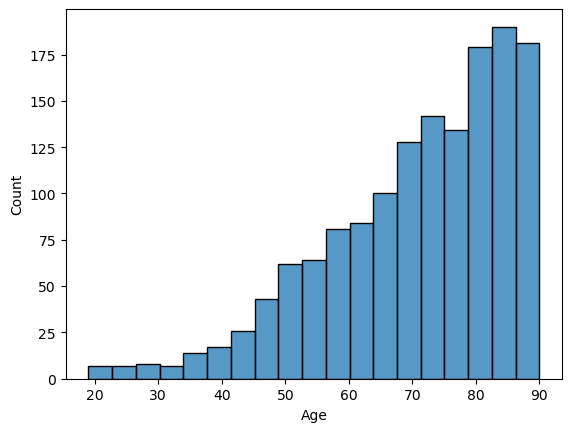

In [36]:
sns.histplot(icu_data, x="Age")

<Axes: xlabel='Gender', ylabel='Count'>

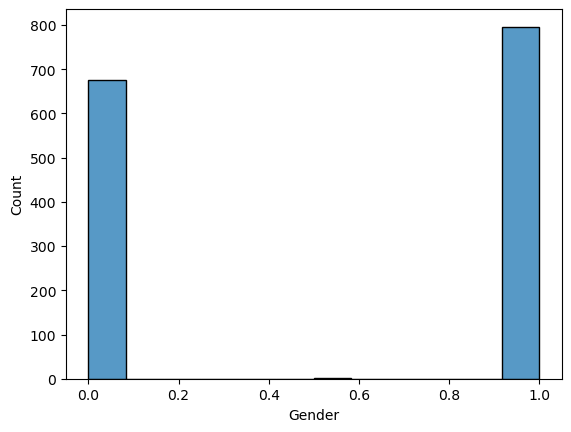

In [38]:
sns.histplot(icu_data, x="Gender")

In [40]:
icu_data = icu_data[icu_data["Gender"].isin([1., 0.])]

<Axes: xlabel='Age', ylabel='Height'>

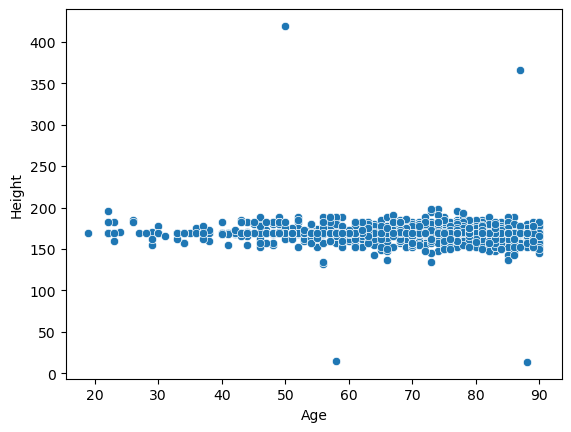

In [42]:
sns.scatterplot(icu_data, x="Age", y="Height")

In [44]:
corr_data = icu_data[['Gender', 'Age', 'Height', 'SAPS.I', 'SOFA', 'In.hospital_death']]
corr_data.corr()

,Gender,Age,Height,SAPS.I,SOFA,In.hospital_death
Gender,1.000000,-0.086790,0.267442,0.013453,0.090401,0.002700
Age,-0.086790,1.000000,-0.083626,0.109851,-0.083953,-0.044521
Height,0.267442,-0.083626,1.000000,-0.009095,0.009908,0.001125
SAPS.I,0.013453,0.109851,-0.009095,1.000000,0.536143,0.167232
SOFA,0.090401,-0.083953,0.009908,0.536143,1.000000,0.223795
In.hospital_death,0.002700,-0.044521,0.001125,0.167232,0.223795,1.000000


In [46]:
icu_x = icu_data.filter(regex="x$",axis=1)
icu_x

,Mean_Weight.x,Mean_GCS.x,Mean_HR.x,Mean_NIDiasABP.x,Mean_NIMAP.x,Mean_NISysABP.x,Mean_RespRate.x,Mean_Temp.x,Mean_Urine.x,Mean_BUN.x,...,Max_SaO2.x,Max_Albumax.x,Max_ALP.x,Max_ALT.x,Max_AST.x,Max_Bilirubin.x,Max_Lactate.x,Max_Cholesterol.x,Max_TroponinI.x,Max_TroponinT.x
0,84.600000,14.888889,72.971429,65.970588,84.951471,122.911765,15.818182,36.214286,466.666667,21.5,...,97.487151,4.400000,105.00000,12.000000,15.000000,0.200000,2.984208,156.684211,8.147317,1.271183
1,83.054136,15.000000,79.520000,49.333333,78.748095,137.571429,19.720000,37.000000,59.800000,45.0,...,97.487151,3.300000,107.83955,193.006395,294.350348,1.980606,2.984208,156.684211,8.147317,1.271183
2,114.000000,8.333333,81.318182,70.500000,81.985000,105.000000,19.666415,37.100000,237.500000,17.0,...,97.000000,3.009175,101.00000,60.000000,162.000000,0.400000,2.984208,212.000000,1.300000,1.271183
3,48.400000,13.250000,78.125000,28.000000,54.499545,107.500000,19.666415,37.133333,51.210526,69.0,...,97.000000,1.900000,47.00000,46.000000,82.000000,0.300000,2.000000,156.684211,3.500000,1.271183
4,60.700000,15.000000,129.363636,65.454545,85.605455,125.909091,35.409091,37.040000,233.333333,21.0,...,97.487151,3.009175,107.83955,193.006395,294.350348,1.980606,2.984208,156.684211,8.147317,1.271183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,64.000000,11.214286,86.260870,60.041667,82.788333,128.291667,19.565217,37.000000,116.470588,12.5,...,97.487151,3.600000,107.83955,193.006395,294.350348,1.980606,2.984208,156.684211,8.147317,1.271183
1470,53.000000,13.000000,85.517241,40.576271,67.541695,121.474576,19.666415,37.166667,67.142857,57.0,...,97.487151,2.600000,192.00000,35.000000,37.000000,1.100000,2.984208,156.684211,8.147317,1.271183
1471,75.000000,9.909091,91.147059,57.213827,75.982764,116.454270,19.666415,36.812500,120.318182,9.5,...,98.000000,3.009175,107.83955,193.006395,294.350348,1.980606,2.984208,156.684211,8.147317,1.271183
1472,87.000000,10.833333,101.083333,60.400000,75.733000,106.400000,19.666415,36.642857,57.823529,14.0,...,97.487151,3.009175,107.83955,193.006395,294.350348,1.980606,3.000000,156.684211,8.147317,1.271183


In [48]:
icu_y = icu_data.filter(regex="y$",axis=1)
icu_y

,Mean_Weight.y,Mean_GCS.y,Mean_HR.y,Mean_NIDiasABP.y,Mean_NIMAP.y,Mean_NISysABP.y,Mean_RespRate.y,Mean_Temp.y,Mean_Urine.y,Mean_BUN.y,...,Max_SaO2.y,Max_Albumax.y,Max_ALP.y,Max_ALT.y,Max_AST.y,Max_Bilirubin.y,Max_Lactate.y,Max_Cholesterol.y,Max_TroponinI.y,Max_TroponinT.y
0,84.600000,15.000000,68.200000,63.750000,82.375417,119.625000,15.000000,36.233333,625.000000,10.0,...,97.151955,4.400000,105.000000,12.000000,15.000000,0.200000,2.395461,156.842105,7.132683,1.114629
1,83.308061,15.000000,70.000000,42.272727,71.317727,129.409091,18.565217,36.640000,64.722222,25.0,...,97.151955,3.300000,105.561871,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629
2,114.000000,8.888889,94.880000,70.500000,81.985000,105.000000,19.648290,37.816667,68.888889,16.5,...,98.000000,2.974458,101.000000,60.000000,162.000000,0.400000,2.395461,212.000000,1.300000,1.114629
3,48.400000,9.600000,65.341463,33.523810,55.888571,100.619048,19.648290,36.980000,36.000000,58.0,...,98.000000,1.900000,47.000000,46.000000,82.000000,0.300000,2.300000,156.842105,3.500000,1.114629
4,60.700000,15.000000,125.291667,63.583333,83.443333,123.166667,34.500000,36.760000,250.000000,23.0,...,97.151955,2.974458,105.561871,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,64.000000,10.777778,85.833333,61.166667,87.071667,138.888889,19.555556,36.825000,159.062500,14.0,...,97.151955,3.600000,105.561871,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629
1470,53.000000,14.666667,77.869565,45.750000,71.499500,123.000000,19.648290,36.716667,71.545455,69.0,...,97.151955,2.600000,155.000000,28.000000,35.000000,0.900000,2.395461,156.842105,7.132683,1.114629
1471,75.000000,10.000000,102.458333,57.441366,76.579340,117.843210,19.648290,37.250000,154.583333,15.0,...,98.000000,2.974458,105.561871,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629
1472,87.000000,14.750000,97.642857,68.100000,85.967000,121.700000,19.648290,37.185714,45.318182,18.0,...,97.151955,2.974458,105.561871,189.169186,260.323666,1.979557,1.100000,156.842105,7.132683,1.114629


In [50]:
sample_1 = icu_data.sample(n=10, axis=1)
corr_1 = sample_1.corr()
corr_1

,Mean_Urine.x,Mean_PaO2.x,Mean_MechVent.y,Mean_BUN.y,Min_AST.x,Mean_K.x,Max_Albumax.y,Max_Creatinine.x,Min_PaO2.x,Max_NISysABP.x
Mean_Urine.x,1.000000,0.036259,NaN,-0.201918,-0.045796,-0.118960,0.116437,-0.156103,0.047081,0.052068
Mean_PaO2.x,0.036259,1.000000,NaN,-0.152694,-0.030707,-0.064945,0.058072,-0.077992,0.742866,0.034671
Mean_MechVent.y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mean_BUN.y,-0.201918,-0.152694,NaN,1.000000,0.049300,0.320297,-0.059257,0.613589,-0.122174,-0.075992
Min_AST.x,-0.045796,-0.030707,NaN,0.049300,1.000000,0.055826,0.007631,0.079301,-0.046644,-0.028322
Mean_K.x,-0.118960,-0.064945,NaN,0.320297,0.055826,1.000000,0.011281,0.344709,-0.115922,-0.096997
Max_Albumax.y,0.116437,0.058072,NaN,-0.059257,0.007631,0.011281,1.000000,-0.003653,0.067014,0.148991
Max_Creatinine.x,-0.156103,-0.077992,NaN,0.613589,0.079301,0.344709,-0.003653,1.000000,-0.066368,-0.006972
Min_PaO2.x,0.047081,0.742866,NaN,-0.122174,-0.046644,-0.115922,0.067014,-0.066368,1.000000,0.087748
Max_NISysABP.x,0.052068,0.034671,NaN,-0.075992,-0.028322,-0.096997,0.148991,-0.006972,0.087748,1.000000


In [52]:
corr_1 = corr_1.replace(1.0, None)

In [54]:
corr1_unstack = corr_1.unstack()


# K-Mean Clustering

In [57]:
k=int(np.sqrt(len(icu_data)/2))

X = icu_data.drop(columns=["RecordID"])

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

labels = kmeans.labels_
representatives = []
for cluster_id in range(k):
    cluster_points = X[labels == cluster_id]
    centroid = kmeans.cluster_centers_[cluster_id]
    closest_idx = np.argmin(((cluster_points - centroid)**2).sum(axis=1))
    representatives.append(cluster_points.iloc[closest_idx])

reduced_data = pd.DataFrame(representatives, columns=X.columns)

In [59]:
reduced_data

,Age,Gender,Height,ICUType2,ICUType3,ICUType4,Mean_Weight.x,Mean_GCS.x,Mean_HR.x,Mean_NIDiasABP.x,...,Max_ALT.y,Max_AST.y,Max_Bilirubin.y,Max_Lactate.y,Max_Cholesterol.y,Max_TroponinI.y,Max_TroponinT.y,SAPS.I,SOFA,In.hospital_death
1313,56.0,0.0,132.100000,0.0,0.0,1.0,41.369767,9.600000,85.300000,60.500000,...,35.000000,28.000000,0.300000,1.800000,156.842105,7.132683,1.114629,12.0,7.0,1.0
1371,68.0,1.0,170.200000,0.0,0.0,0.0,87.740299,9.400000,73.710526,60.277778,...,321.000000,8800.000000,1.400000,12.400000,156.842105,7.132683,0.620000,-1.0,15.0,1.0
680,63.0,0.0,160.000000,0.0,0.0,1.0,92.363636,8.333333,104.500000,57.213827,...,1797.000000,4504.000000,10.200000,7.700000,156.842105,7.132683,1.114629,21.0,15.0,1.0
388,63.0,1.0,169.787227,0.0,1.0,0.0,149.000000,6.375000,114.548387,55.444444,...,2617.000000,1444.000000,1.400000,1.900000,156.842105,7.132683,1.114629,18.0,15.0,0.0
878,44.0,0.0,170.200000,0.0,0.0,0.0,99.485714,4.300000,132.230769,57.213827,...,4940.000000,15680.000000,0.500000,10.500000,156.842105,7.132683,2.180000,24.0,16.0,1.0
7,84.0,1.0,182.900000,0.0,1.0,0.0,82.500000,14.714286,94.636364,41.096774,...,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629,9.0,2.0,0.0
104,60.0,1.0,169.787227,0.0,1.0,0.0,118.400000,3.250000,123.706897,38.736842,...,8126.000000,18430.000000,13.100000,24.100000,156.842105,7.132683,0.080000,33.0,22.0,1.0
81,72.0,0.0,157.500000,1.0,0.0,0.0,61.575000,4.400000,100.304348,46.250000,...,3599.000000,9820.000000,2.900000,5.500000,174.000000,7.132683,1.114629,28.0,14.0,0.0
373,35.0,0.0,169.787227,0.0,1.0,0.0,39.800000,9.857143,62.227273,59.095238,...,1343.000000,1785.000000,0.800000,1.200000,156.842105,7.132683,0.390000,11.0,5.0,0.0
484,22.0,0.0,169.787227,0.0,1.0,0.0,65.532813,11.166667,130.319149,57.500000,...,3867.000000,4522.000000,5.800000,5.500000,88.000000,7.132683,1.114629,20.0,10.0,1.0


# Random Forest for 48hr

In [62]:
X = icu_data.drop(columns=["In.hospital_death", "RecordID"])
Y = icu_data["In.hospital_death"].values

In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y)

rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, Y_train)

print("Training accuracy:", rf.score(X_train, Y_train))
print("Test accuracy:", rf.score(X_test, Y_test))

Training accuracy: 1.0
Test accuracy: 0.7472826086956522


In [65]:
impurity_importance = pd.DataFrame({
    "feature": X.columns,
    "importance_impurity": rf.feature_importances_
}).sort_values("importance_impurity", ascending=False)

print(impurity_importance.head(20))

            feature  importance_impurity
118      Mean_GCS.y             0.034170
192       Max_GCS.y             0.023803
155       Min_GCS.y             0.016950
125    Mean_Urine.y             0.011889
7        Mean_GCS.x             0.011837
199     Max_Urine.y             0.010897
82         Max_HR.x             0.010423
119       Mean_HR.y             0.009436
14     Mean_Urine.x             0.008873
202   Max_Glucose.y             0.008421
8         Mean_HR.x             0.008278
156        Min_HR.y             0.007867
193        Max_HR.y             0.007846
32    Mean_SysABP.x             0.007325
187   Min_Lactate.y             0.007265
29      Mean_FiO2.x             0.007202
143   Mean_SysABP.y             0.007108
106    Max_SysABP.x             0.006887
124     Mean_Temp.y             0.006767
150  Mean_Lactate.y             0.006575


In [66]:
perm = permutation_importance(
    rf, X_test, Y_test, 
    n_repeats=10,     # how many times to shuffle
    scoring="roc_auc",# metric: how much AUC drops
    random_state=42
)

perm_importance = pd.DataFrame({
    "feature": X.columns,
    "importance_perm": perm.importances_mean,
    "std": perm.importances_std
}).sort_values("importance_perm", ascending=False)

print(perm_importance.head(20))

              feature  importance_perm       std
118        Mean_GCS.y         0.023061  0.007450
192         Max_GCS.y         0.014089  0.004791
155         Min_GCS.y         0.007187  0.002865
81          Max_GCS.x         0.002470  0.001277
7          Mean_GCS.x         0.002057  0.002014
76      Min_Lactate.x         0.001886  0.000576
91      Max_Glucose.x         0.001556  0.000674
111         Max_AST.x         0.001405  0.000800
50         Min_Temp.x         0.001402  0.000369
172         Min_WBC.y         0.001342  0.001013
187     Min_Lactate.y         0.001284  0.000839
18        Mean_HCO3.x         0.001278  0.000604
135        Mean_WBC.y         0.001232  0.000612
27        Mean_PaO2.x         0.001144  0.000653
136         Mean_pH.y         0.001134  0.000535
125      Mean_Urine.y         0.001027  0.001960
224     Max_Lactate.y         0.000994  0.000728
149  Mean_Bilirubin.y         0.000920  0.000640
101        Max_PaO2.x         0.000907  0.000283
103        Max_FiO2.

## RF for First 24hr

In [70]:
icu_x = icu_x.join(icu_data["In.hospital_death"])
X_x = icu_x.drop(columns=["In.hospital_death"])
Y_x = icu_x["In.hospital_death"]

In [73]:
X_x_train, X_x_test, Y_x_train, Y_x_test = train_test_split(X_x, Y_x, test_size=0.25, random_state=42, stratify=Y_x)

rf_x = RandomForestClassifier(n_estimators=500, random_state=42)
rf_x.fit(X_x_train, Y_x_train)

print("Training accuracy:", rf_x.score(X_x_train, Y_x_train))
print("Test accuracy:", rf_x.score(X_x_test, Y_x_test))

Training accuracy: 1.0
Test accuracy: 0.7038043478260869


In [75]:
impurity_importance_x = pd.DataFrame({
    "feature": X_x.columns,
    "importance_impurity": rf_x.feature_importances_
}).sort_values("importance_impurity", ascending=False)

print(impurity_importance_x.head(20))

              feature  importance_impurity
1          Mean_GCS.x             0.028975
76           Max_HR.x             0.020279
8        Mean_Urine.x             0.018026
2           Mean_HR.x             0.017002
23        Mean_FiO2.x             0.016272
26      Mean_SysABP.x             0.016209
75          Max_GCS.x             0.016074
100      Max_SysABP.x             0.014862
70      Min_Lactate.x             0.014495
58         Min_PaO2.x             0.013837
20       Mean_PaCO2.x             0.013125
56           Min_pH.x             0.013121
12        Mean_HCO3.x             0.012788
39           Min_HR.x             0.012478
82        Max_Urine.x             0.012368
52    Min_Platelets.x             0.012135
33     Mean_Lactate.x             0.012025
15   Mean_Platelets.x             0.012012
107     Max_Lactate.x             0.011859
49         Min_HCO3.x             0.011695


# Linear for Delta for 48hr

In [78]:
delta_features = {}

for col in icu_data.columns:
    if col.endswith(".x"):
        base_name = col[:-2]
        col_x = f"{base_name}.x"
        col_y = f"{base_name}.y"
        if col_y in icu_data.columns:
            delta_features[f"{base_name}_delta"] = icu_data[col_y] - icu_data[col_x]
delta_df = pd.DataFrame(delta_features)
delta_df

,Mean_Weight_delta,Mean_GCS_delta,Mean_HR_delta,Mean_NIDiasABP_delta,Mean_NIMAP_delta,Mean_NISysABP_delta,Mean_RespRate_delta,Mean_Temp_delta,Mean_Urine_delta,Mean_BUN_delta,...,Max_SaO2_delta,Max_Albumax_delta,Max_ALP_delta,Max_ALT_delta,Max_AST_delta,Max_Bilirubin_delta,Max_Lactate_delta,Max_Cholesterol_delta,Max_TroponinI_delta,Max_TroponinT_delta
0,0.000000,0.111111,-4.771429,-2.220588,-2.576054,-3.286765,-0.818182,0.019048,158.333333,-11.5,...,-0.335196,0.000000,0.000000,0.000000,0.000000,0.000000,-0.588747,0.157895,-1.014634,-0.156555
1,0.253925,0.000000,-9.520000,-7.060606,-7.430368,-8.162338,-1.154783,-0.360000,4.922222,-20.0,...,-0.335196,0.000000,-2.277679,-3.837209,-34.026682,-0.001048,-0.588747,0.157895,-1.014634,-0.156555
2,0.000000,0.555556,13.561818,0.000000,0.000000,0.000000,-0.018125,0.716667,-168.611111,-0.5,...,1.000000,-0.034718,0.000000,0.000000,0.000000,0.000000,-0.588747,0.000000,0.000000,-0.156555
3,0.000000,-3.650000,-12.783537,5.523810,1.389026,-6.880952,-0.018125,-0.153333,-15.210526,-11.0,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,0.157895,0.000000,-0.156555
4,0.000000,0.000000,-4.071970,-1.871212,-2.162121,-2.742424,-0.909091,-0.280000,16.666667,2.0,...,-0.335196,-0.034718,-2.277679,-3.837209,-34.026682,-0.001048,-0.588747,0.157895,-1.014634,-0.156555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,0.000000,-0.436508,-0.427536,1.125000,4.283333,10.597222,-0.009662,-0.175000,42.591912,1.5,...,-0.335196,0.000000,-2.277679,-3.837209,-34.026682,-0.001048,-0.588747,0.157895,-1.014634,-0.156555
1470,0.000000,1.666667,-7.647676,5.173729,3.957805,1.525424,-0.018125,-0.450000,4.402597,12.0,...,-0.335196,0.000000,-37.000000,-7.000000,-2.000000,-0.200000,-0.588747,0.157895,-1.014634,-0.156555
1471,0.000000,0.090909,11.311275,0.227539,0.596576,1.388940,-0.018125,0.437500,34.265152,5.5,...,0.000000,-0.034718,-2.277679,-3.837209,-34.026682,-0.001048,-0.588747,0.157895,-1.014634,-0.156555
1472,0.000000,3.916667,-3.440476,7.700000,10.234000,15.300000,-0.018125,0.542857,-12.505348,4.0,...,-0.335196,-0.034718,-2.277679,-3.837209,-34.026682,-0.001048,-1.900000,0.157895,-1.014634,-0.156555


In [84]:
X = delta_df
y = icu_data["In.hospital_death"]

model = LinearRegression()
model.fit(X, y)
importance = pd.DataFrame({
    "feature": X.columns,
    "coef": model.coef_
}).sort_values(by="coef", key=abs, ascending=False)

print(importance)

                   feature          coef
28      Mean_Albumin_delta  2.439446e+00
102      Max_Albumax_delta -1.364479e+00
65       Min_Albumin_delta -1.180885e+00
23         Mean_FiO2_delta -5.209596e-01
10   Mean_Creatinine_delta  4.231176e-01
..                     ...           ...
82         Max_Urine_delta -1.929434e-05
24          Mean_MAP_delta  7.269206e-06
25     Mean_MechVent_delta  4.120333e-13
62      Min_MechVent_delta  1.071643e-13
99      Max_MechVent_delta  2.220446e-16

[111 rows x 2 columns]


# ICUType Selection

In [87]:
icu_x

,Mean_Weight.x,Mean_GCS.x,Mean_HR.x,Mean_NIDiasABP.x,Mean_NIMAP.x,Mean_NISysABP.x,Mean_RespRate.x,Mean_Temp.x,Mean_Urine.x,Mean_BUN.x,...,Max_Albumax.x,Max_ALP.x,Max_ALT.x,Max_AST.x,Max_Bilirubin.x,Max_Lactate.x,Max_Cholesterol.x,Max_TroponinI.x,Max_TroponinT.x,In.hospital_death
0,84.600000,14.888889,72.971429,65.970588,84.951471,122.911765,15.818182,36.214286,466.666667,21.5,...,4.400000,105.00000,12.000000,15.000000,0.200000,2.984208,156.684211,8.147317,1.271183,0
1,83.054136,15.000000,79.520000,49.333333,78.748095,137.571429,19.720000,37.000000,59.800000,45.0,...,3.300000,107.83955,193.006395,294.350348,1.980606,2.984208,156.684211,8.147317,1.271183,0
2,114.000000,8.333333,81.318182,70.500000,81.985000,105.000000,19.666415,37.100000,237.500000,17.0,...,3.009175,101.00000,60.000000,162.000000,0.400000,2.984208,212.000000,1.300000,1.271183,0
3,48.400000,13.250000,78.125000,28.000000,54.499545,107.500000,19.666415,37.133333,51.210526,69.0,...,1.900000,47.00000,46.000000,82.000000,0.300000,2.000000,156.684211,3.500000,1.271183,1
4,60.700000,15.000000,129.363636,65.454545,85.605455,125.909091,35.409091,37.040000,233.333333,21.0,...,3.009175,107.83955,193.006395,294.350348,1.980606,2.984208,156.684211,8.147317,1.271183,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,64.000000,11.214286,86.260870,60.041667,82.788333,128.291667,19.565217,37.000000,116.470588,12.5,...,3.600000,107.83955,193.006395,294.350348,1.980606,2.984208,156.684211,8.147317,1.271183,0
1470,53.000000,13.000000,85.517241,40.576271,67.541695,121.474576,19.666415,37.166667,67.142857,57.0,...,2.600000,192.00000,35.000000,37.000000,1.100000,2.984208,156.684211,8.147317,1.271183,0
1471,75.000000,9.909091,91.147059,57.213827,75.982764,116.454270,19.666415,36.812500,120.318182,9.5,...,3.009175,107.83955,193.006395,294.350348,1.980606,2.984208,156.684211,8.147317,1.271183,0
1472,87.000000,10.833333,101.083333,60.400000,75.733000,106.400000,19.666415,36.642857,57.823529,14.0,...,3.009175,107.83955,193.006395,294.350348,1.980606,3.000000,156.684211,8.147317,1.271183,0


In [89]:
icu_x = icu_x.join(icu_data["ICUType2"]).join(icu_data["ICUType3"]).join(icu_data["ICUType4"])
icu_x

,Mean_Weight.x,Mean_GCS.x,Mean_HR.x,Mean_NIDiasABP.x,Mean_NIMAP.x,Mean_NISysABP.x,Mean_RespRate.x,Mean_Temp.x,Mean_Urine.x,Mean_BUN.x,...,Max_AST.x,Max_Bilirubin.x,Max_Lactate.x,Max_Cholesterol.x,Max_TroponinI.x,Max_TroponinT.x,In.hospital_death,ICUType2,ICUType3,ICUType4
0,84.600000,14.888889,72.971429,65.970588,84.951471,122.911765,15.818182,36.214286,466.666667,21.5,...,15.000000,0.200000,2.984208,156.684211,8.147317,1.271183,0,0,1,0
1,83.054136,15.000000,79.520000,49.333333,78.748095,137.571429,19.720000,37.000000,59.800000,45.0,...,294.350348,1.980606,2.984208,156.684211,8.147317,1.271183,0,0,1,0
2,114.000000,8.333333,81.318182,70.500000,81.985000,105.000000,19.666415,37.100000,237.500000,17.0,...,162.000000,0.400000,2.984208,212.000000,1.300000,1.271183,0,0,0,0
3,48.400000,13.250000,78.125000,28.000000,54.499545,107.500000,19.666415,37.133333,51.210526,69.0,...,82.000000,0.300000,2.000000,156.684211,3.500000,1.271183,1,0,1,0
4,60.700000,15.000000,129.363636,65.454545,85.605455,125.909091,35.409091,37.040000,233.333333,21.0,...,294.350348,1.980606,2.984208,156.684211,8.147317,1.271183,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,64.000000,11.214286,86.260870,60.041667,82.788333,128.291667,19.565217,37.000000,116.470588,12.5,...,294.350348,1.980606,2.984208,156.684211,8.147317,1.271183,0,0,0,1
1470,53.000000,13.000000,85.517241,40.576271,67.541695,121.474576,19.666415,37.166667,67.142857,57.0,...,37.000000,1.100000,2.984208,156.684211,8.147317,1.271183,0,0,1,0
1471,75.000000,9.909091,91.147059,57.213827,75.982764,116.454270,19.666415,36.812500,120.318182,9.5,...,294.350348,1.980606,2.984208,156.684211,8.147317,1.271183,0,0,0,1
1472,87.000000,10.833333,101.083333,60.400000,75.733000,106.400000,19.666415,36.642857,57.823529,14.0,...,294.350348,1.980606,3.000000,156.684211,8.147317,1.271183,0,0,0,1


In [189]:
icu_one = icu_x[
    (icu_x["ICUType2"] == 0) &
    (icu_x["ICUType3"] == 0) &
    (icu_x["ICUType4"] == 0)
].join(icu_data["Age"]).join(icu_data["Height"])
icu_one

,Mean_Weight.x,Mean_GCS.x,Mean_HR.x,Mean_NIDiasABP.x,Mean_NIMAP.x,Mean_NISysABP.x,Mean_RespRate.x,Mean_Temp.x,Mean_Urine.x,Mean_BUN.x,...,Max_Lactate.x,Max_Cholesterol.x,Max_TroponinI.x,Max_TroponinT.x,In.hospital_death,ICUType2,ICUType3,ICUType4,Age,Height
2,114.000000,8.333333,81.318182,70.500000,81.985000,105.000000,19.666415,37.100000,237.500000,17.000000,...,2.984208,212.000000,1.300000,1.271183,0,0,0,0,64,180.300000
5,92.892593,15.000000,74.000000,45.520000,79.599600,147.760000,16.800000,36.942857,100.357143,44.000000,...,2.984208,156.684211,6.600000,1.271183,0,0,0,0,77,162.600000
17,59.000000,15.000000,70.863636,39.428571,57.427143,93.428571,19.666415,37.016667,50.428571,49.000000,...,2.984208,156.684211,8.147317,1.271183,0,0,0,0,77,162.600000
19,75.096296,15.000000,76.210526,38.578947,58.526842,98.421053,19.666415,36.400000,165.625000,110.500000,...,2.984208,156.684211,8.147317,1.271183,1,0,0,0,77,170.200000
26,165.000000,14.714286,99.681818,68.333333,76.000000,91.333333,19.666415,36.466667,11.888889,47.000000,...,1.900000,156.684211,8.147317,1.271183,1,0,0,0,61,170.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,54.863158,7.125000,66.200000,45.000000,66.475000,109.423077,19.666415,37.328571,121.333333,57.000000,...,2.984208,156.684211,8.147317,1.271183,0,0,0,0,89,152.400000
1446,114.264706,15.000000,78.634146,40.000000,58.556667,95.666667,19.666415,36.380000,140.648126,61.500000,...,2.984208,156.684211,8.147317,0.170000,0,0,0,0,62,172.700000
1451,91.000000,15.000000,69.960000,58.956522,83.187826,131.652174,20.375000,36.200000,217.750000,69.000000,...,2.984208,156.684211,8.147317,1.271183,0,0,0,0,79,175.300000
1456,109.000000,7.375000,109.090909,51.000000,69.553333,106.666667,19.666415,36.985714,93.250000,34.666667,...,2.700000,156.684211,8.147317,1.271183,0,0,0,0,68,182.900000


<Axes: xlabel='Age', ylabel='Count'>

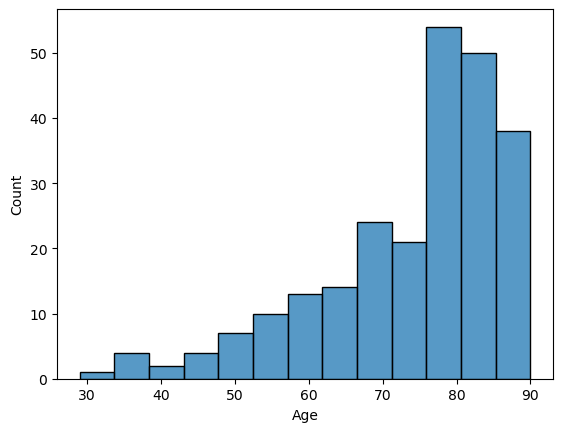

In [191]:
sns.histplot(icu_one, x="Age")

<Axes: xlabel='Age', ylabel='Mean_Weight.x'>

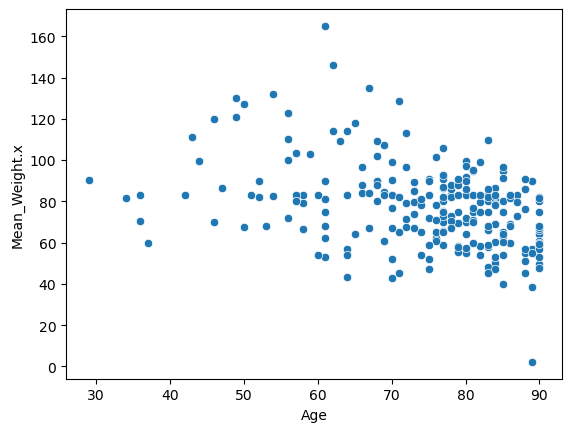

In [193]:
sns.scatterplot(icu_one,  x="Age", y="Mean_Weight.x")

In [143]:
icu_two = icu_x[icu_x["ICUType2"].isin([1])].join(icu_data["Age"]).join(icu_data["Height"])
icu_two

,Mean_Weight.x,Mean_GCS.x,Mean_HR.x,Mean_NIDiasABP.x,Mean_NIMAP.x,Mean_NISysABP.x,Mean_RespRate.x,Mean_Temp.x,Mean_Urine.x,Mean_BUN.x,...,Max_Lactate.x,Max_Cholesterol.x,Max_TroponinI.x,Max_TroponinT.x,In.hospital_death,ICUType2,ICUType3,ICUType4,Age,Height
10,105.846154,9.500000,98.138889,55.000000,75.670000,117.000000,19.666415,37.480645,156.904762,15.500000,...,4.000000,156.684211,8.147317,1.271183,0,1,0,0,58,188.000000
21,66.000000,8.666667,80.558824,57.213827,75.982764,116.454270,19.666415,38.126471,248.181818,9.000000,...,2.984208,156.684211,8.147317,1.271183,0,1,0,0,87,157.500000
22,107.937500,8.142857,87.734694,56.750000,74.500000,110.000000,19.666415,37.533333,225.952381,12.000000,...,2.984208,156.684211,8.147317,1.271183,0,1,0,0,81,185.400000
59,86.183636,8.571429,91.209302,57.213827,75.982764,116.454270,19.666415,36.981481,89.041667,13.000000,...,2.984208,156.684211,8.147317,1.271183,0,1,0,0,62,162.600000
78,91.212500,3.142857,78.982456,47.000000,55.000000,81.000000,19.666415,36.233333,48.333333,36.333333,...,1.900000,156.684211,8.147317,0.450000,1,1,0,0,71,177.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1416,102.533333,10.000000,71.387097,41.500000,64.000000,109.000000,19.666415,37.273913,120.000000,18.000000,...,2.984208,156.684211,8.147317,1.271183,0,1,0,0,83,182.900000
1422,62.000000,15.000000,71.733333,52.100000,83.423667,146.066667,24.833333,37.483333,158.750000,26.500000,...,1.400000,202.000000,8.147317,1.271183,1,1,0,0,71,169.787227
1425,62.333333,14.000000,84.880000,62.500000,69.000000,88.500000,25.720000,36.466667,62.500000,36.000000,...,2.300000,156.684211,8.147317,0.050000,1,1,0,0,90,149.900000
1427,71.272414,14.954545,77.521739,62.636364,79.846364,114.272727,17.000000,37.142857,155.357143,15.000000,...,2.984208,156.684211,8.147317,1.271183,0,1,0,0,58,169.787227


<Axes: xlabel='Age', ylabel='Count'>

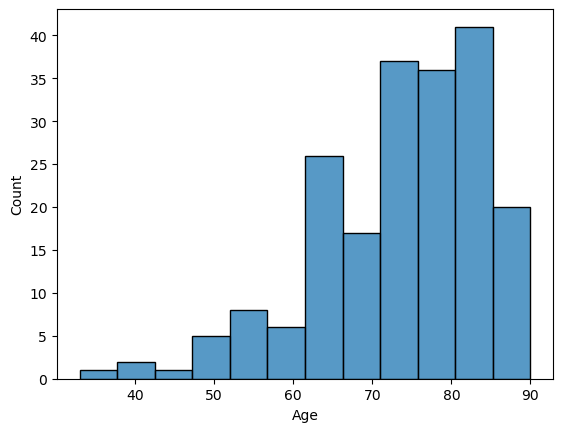

In [145]:
sns.histplot(icu_two, x="Age")

<Axes: xlabel='Age', ylabel='Mean_Weight.x'>

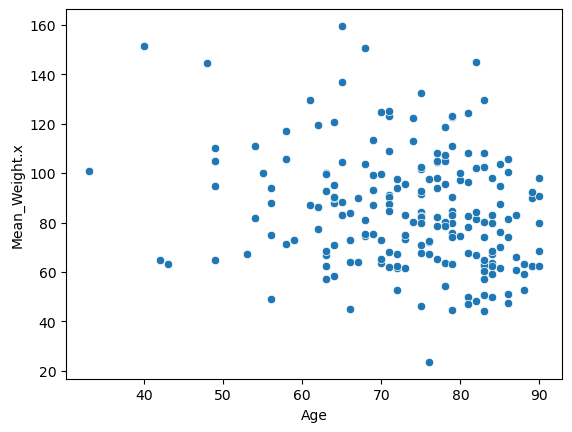

In [147]:
sns.scatterplot(icu_two,  x="Age", y="Mean_Weight.x")

<Axes: xlabel='Age', ylabel='Height'>

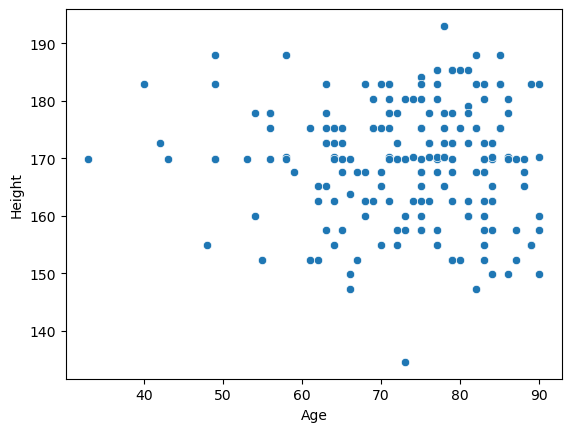

In [149]:
sns.scatterplot(icu_two,  x="Age", y="Height")

In [151]:
icu_three = icu_x[icu_x["ICUType3"].isin([1])].join(icu_data["Age"]).join(icu_data["Height"])
icu_three

,Mean_Weight.x,Mean_GCS.x,Mean_HR.x,Mean_NIDiasABP.x,Mean_NIMAP.x,Mean_NISysABP.x,Mean_RespRate.x,Mean_Temp.x,Mean_Urine.x,Mean_BUN.x,...,Max_Lactate.x,Max_Cholesterol.x,Max_TroponinI.x,Max_TroponinT.x,In.hospital_death,ICUType2,ICUType3,ICUType4,Age,Height
0,84.600000,14.888889,72.971429,65.970588,84.951471,122.911765,15.818182,36.214286,466.666667,21.5,...,2.984208,156.684211,8.147317,1.271183,0,0,1,0,68,180.300000
1,83.054136,15.000000,79.520000,49.333333,78.748095,137.571429,19.720000,37.000000,59.800000,45.0,...,2.984208,156.684211,8.147317,1.271183,0,0,1,0,88,169.787227
3,48.400000,13.250000,78.125000,28.000000,54.499545,107.500000,19.666415,37.133333,51.210526,69.0,...,2.000000,156.684211,3.500000,1.271183,1,0,1,0,78,162.600000
4,60.700000,15.000000,129.363636,65.454545,85.605455,125.909091,35.409091,37.040000,233.333333,21.0,...,2.984208,156.684211,8.147317,1.271183,0,0,1,0,64,169.787227
6,66.574286,10.600000,84.739130,74.909091,99.651818,149.090909,24.608696,37.885714,102.692308,35.5,...,2.984208,156.684211,8.147317,1.271183,0,0,1,0,65,169.787227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1464,61.500000,14.714286,60.044444,40.046512,68.239535,124.627907,18.177778,36.225000,128.437500,57.5,...,2.984208,156.684211,8.147317,1.271183,0,0,1,0,85,169.787227
1466,65.000000,14.727273,52.739130,35.956522,52.507391,85.608696,19.666415,35.466667,29.500000,55.0,...,3.100000,156.684211,8.147317,1.271183,1,0,1,0,74,169.787227
1467,80.700000,15.000000,79.400000,57.250000,83.097000,134.800000,22.900000,36.783333,140.000000,26.5,...,2.984208,156.684211,1.500000,1.271183,0,0,1,0,75,169.787227
1470,53.000000,13.000000,85.517241,40.576271,67.541695,121.474576,19.666415,37.166667,67.142857,57.0,...,2.984208,156.684211,8.147317,1.271183,0,0,1,0,86,162.600000


<Axes: xlabel='Age', ylabel='Count'>

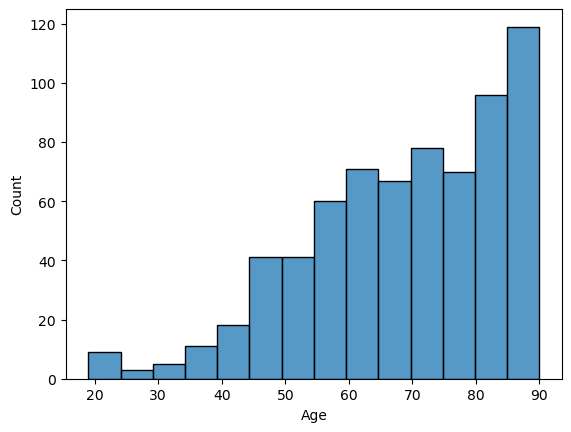

In [153]:
sns.histplot(icu_three, x="Age")

<Axes: xlabel='Age', ylabel='Height'>

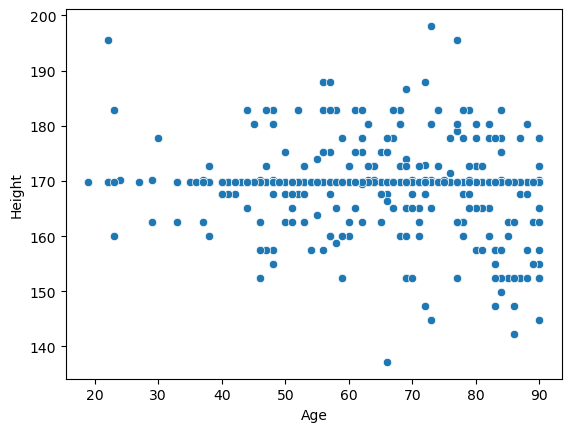

In [155]:
sns.scatterplot(icu_three,  x="Age", y="Height")

<Axes: xlabel='Age', ylabel='Mean_Weight.x'>

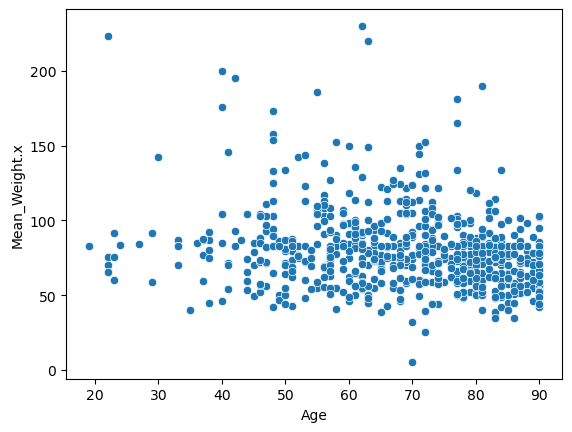

In [157]:
sns.scatterplot(icu_three,  x="Age", y="Mean_Weight.x")

In [159]:
icu_four = icu_x[icu_x["ICUType4"].isin([1])].join(icu_data["Age"]).join(icu_data["Height"])
icu_four

,Mean_Weight.x,Mean_GCS.x,Mean_HR.x,Mean_NIDiasABP.x,Mean_NIMAP.x,Mean_NISysABP.x,Mean_RespRate.x,Mean_Temp.x,Mean_Urine.x,Mean_BUN.x,...,Max_Lactate.x,Max_Cholesterol.x,Max_TroponinI.x,Max_TroponinT.x,In.hospital_death,ICUType2,ICUType3,ICUType4,Age,Height
13,60.000000,7.000000,72.414634,64.029412,86.411471,131.176471,19.666415,37.266667,83.500000,19.000000,...,2.984208,156.684211,8.147317,1.271183,1,0,0,1,80,169.787227
24,66.627500,8.166667,73.068966,60.777778,81.333333,143.777778,19.666415,37.266667,40.000000,30.000000,...,1.300000,156.684211,8.147317,1.271183,1,0,0,1,80,169.787227
25,111.300000,12.000000,91.692308,76.809524,101.418095,150.619048,20.076923,37.042857,153.913043,17.000000,...,2.984208,156.684211,8.147317,1.271183,0,0,0,1,68,157.500000
28,68.900000,3.000000,72.243902,55.090909,66.090909,99.818182,19.666415,36.302632,225.952381,7.666667,...,2.800000,156.684211,8.147317,1.271183,1,0,0,1,63,182.900000
31,101.300000,7.400000,71.454545,42.333333,56.000000,99.333333,19.666415,35.875000,54.888889,84.000000,...,1.200000,156.684211,8.147317,0.060000,1,0,0,1,86,144.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,80.254237,5.181818,91.451613,57.213827,75.982764,116.454270,19.666415,38.228571,88.541667,31.500000,...,1.800000,156.684211,47.500000,1.271183,1,0,0,1,61,182.900000
1465,70.000000,12.384615,92.966667,46.850000,75.032000,131.400000,22.033333,37.083333,78.611111,17.500000,...,1.300000,156.684211,8.147317,0.110000,1,0,0,1,83,180.300000
1469,64.000000,11.214286,86.260870,60.041667,82.788333,128.291667,19.565217,37.000000,116.470588,12.500000,...,2.984208,156.684211,8.147317,1.271183,0,0,0,1,89,177.800000
1471,75.000000,9.909091,91.147059,57.213827,75.982764,116.454270,19.666415,36.812500,120.318182,9.500000,...,2.984208,156.684211,8.147317,1.271183,0,0,0,1,51,169.787227


<Axes: xlabel='Age', ylabel='Count'>

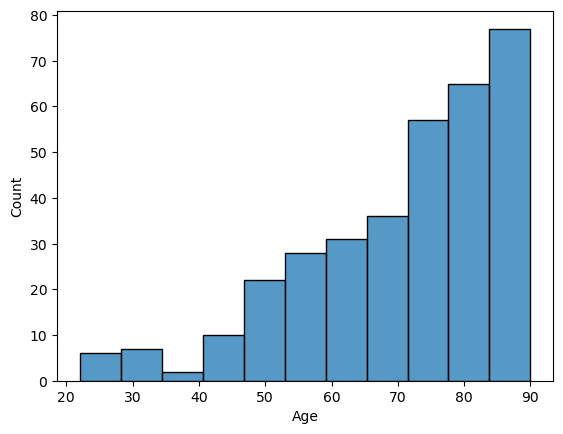

In [161]:
sns.histplot(icu_four, x="Age")

<Axes: xlabel='Age', ylabel='Height'>

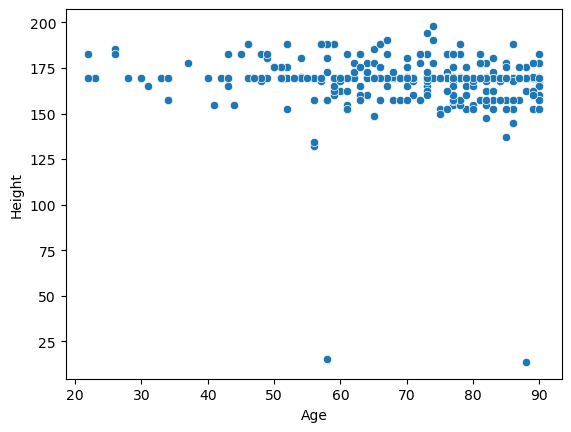

In [163]:
sns.scatterplot(icu_four,  x="Age", y="Height")

<Axes: xlabel='Age', ylabel='Mean_Weight.x'>

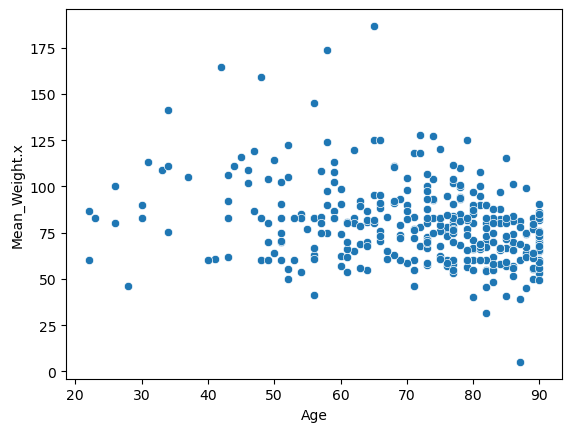

In [165]:
sns.scatterplot(icu_four,  x="Age", y="Mean_Weight.x")

In [167]:
X_type1 = icu_one.drop(columns=["In.hospital_death"])
Y_type1 = icu_one["In.hospital_death"]

X_type2 = icu_two.drop(columns=["In.hospital_death"])
Y_type2 = icu_two["In.hospital_death"]

X_type3 = icu_three.drop(columns=["In.hospital_death"])
Y_type3 = icu_three["In.hospital_death"]

X_type4 = icu_four.drop(columns=["In.hospital_death"])
Y_type4 = icu_four["In.hospital_death"]

In [173]:
feature_importance = []
for X, Y in [(X_type1, Y_type1), (X_type2, Y_type2), (X_type3, Y_type3), (X_type4, Y_type4)]:
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y)
    
    rf = RandomForestClassifier(n_estimators=500, random_state=42)
    rf.fit(X_train, Y_train)
    
    print("Training accuracy:", rf.score(X_train, Y_train))
    print("Test accuracy:", rf.score(X_test, Y_test))
    
    impurity_importance = pd.DataFrame({
        "feature": X.columns,
        "importance_impurity": rf.feature_importances_
    }).sort_values("importance_impurity", ascending=False)

    feature_importance.append(impurity_importance)
    print(impurity_importance.head(20))

Training accuracy: 1.0
Test accuracy: 0.7704918032786885
           feature  importance_impurity
1       Mean_GCS.x             0.042667
75       Max_GCS.x             0.030454
31      Mean_AST.x             0.020746
38       Min_GCS.x             0.020143
57     Min_PaCO2.x             0.019374
45     Min_Urine.x             0.019047
100   Max_SysABP.x             0.018987
104      Max_ALT.x             0.017022
8     Mean_Urine.x             0.017019
26   Mean_SysABP.x             0.016956
20    Mean_PaCO2.x             0.016891
105      Max_AST.x             0.016548
94     Max_PaCO2.x             0.016132
68       Min_AST.x             0.015967
83       Max_BUN.x             0.014909
7      Mean_Temp.x             0.014693
56        Min_pH.x             0.014247
46       Min_BUN.x             0.013620
44      Min_Temp.x             0.013362
74    Max_Weight.x             0.013101
Training accuracy: 1.0
Test accuracy: 0.78
               feature  importance_impurity
12         Mean_

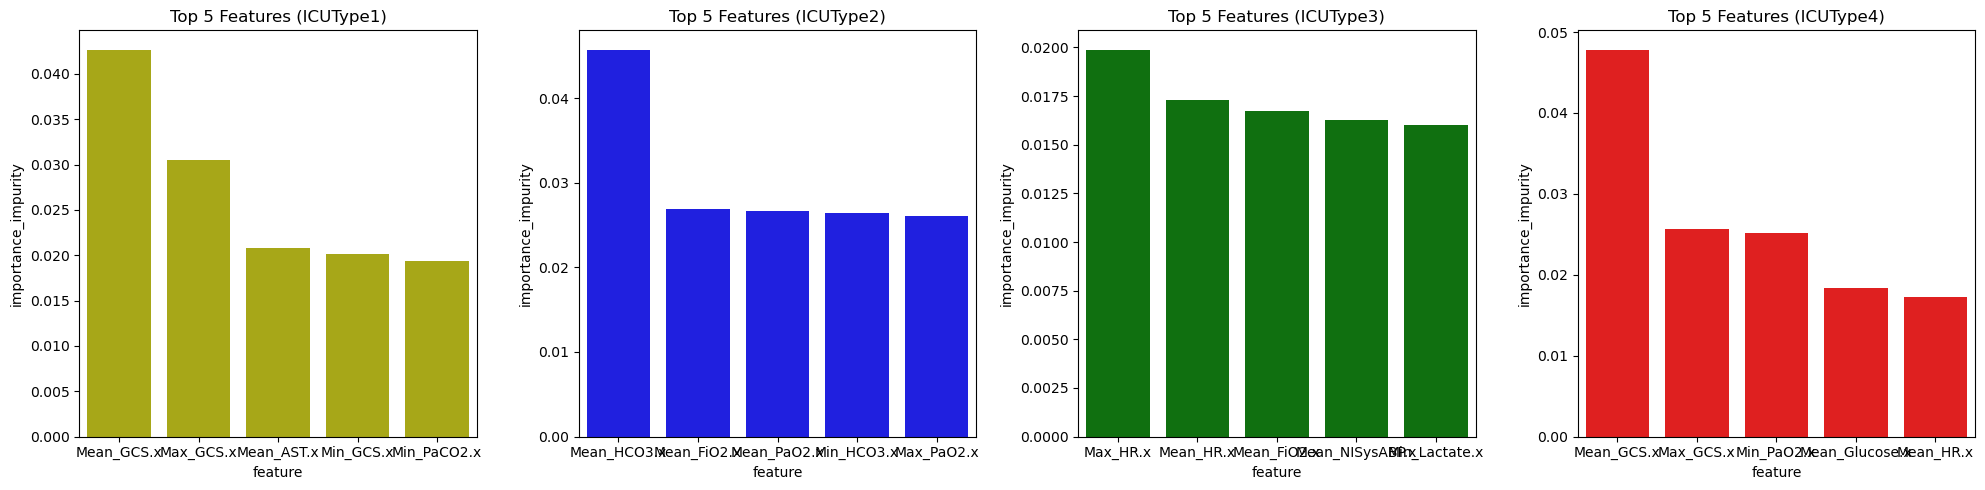

In [183]:
fi_one = feature_importance[0][0:5]
fi_two = feature_importance[1][0:5]
fi_three = feature_importance[2][0:5]
fi_four = feature_importance[3][0:5]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

sns.barplot(data=fi_one, x="feature", y="importance_impurity", color="y", ax=axs[0])
axs[0].set_title("Top 5 Features (ICUType1)")

sns.barplot(data=fi_two, x="feature", y="importance_impurity", color="b", ax=axs[1])
axs[1].set_title("Top 5 Features (ICUType2)")

sns.barplot(data=fi_three, x="feature", y="importance_impurity", color="g", ax=axs[2])
axs[2].set_title("Top 5 Features (ICUType3)")

sns.barplot(data=fi_four, x="feature", y="importance_impurity", color="r", ax=axs[3])
axs[3].set_title("Top 5 Features (ICUType4)")

plt.tight_layout()
plt.show()

In [185]:
i = 1
for X, Y in [(X_type1, Y_type1), (X_type2, Y_type2), (X_type3, Y_type3), (X_type4, Y_type4)]:
    i+=1
        
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y)
    
    rf = RandomForestClassifier(n_estimators=500, random_state=42)
    rf.fit(X_train, Y_train)

    Y_pred = rf.predict_proba(X_test)

    recall = recall_score(Y_test, rf.predict(X_test))

    print(f"Icu Type {i}")
    print("Training accuracy:", rf.score(X_train, Y_train))
    print("Recall score: ", recall)
    print("Test accuracy:", rf.score(X_test, Y_test))
    print("Predicted mortality:", Y_pred)

Icu Type 2
Training accuracy: 1.0
Recall score:  0.4
Test accuracy: 0.7704918032786885
Predicted mortality: [[0.804 0.196]
 [0.296 0.704]
 [0.856 0.144]
 [0.764 0.236]
 [0.862 0.138]
 [0.522 0.478]
 [0.726 0.274]
 [0.518 0.482]
 [0.824 0.176]
 [0.612 0.388]
 [0.864 0.136]
 [0.59  0.41 ]
 [0.852 0.148]
 [0.796 0.204]
 [0.51  0.49 ]
 [0.63  0.37 ]
 [0.728 0.272]
 [0.558 0.442]
 [0.55  0.45 ]
 [0.594 0.406]
 [0.616 0.384]
 [0.54  0.46 ]
 [0.774 0.226]
 [0.266 0.734]
 [0.592 0.408]
 [0.652 0.348]
 [0.852 0.148]
 [0.842 0.158]
 [0.76  0.24 ]
 [0.634 0.366]
 [0.916 0.084]
 [0.572 0.428]
 [0.682 0.318]
 [0.518 0.482]
 [0.388 0.612]
 [0.868 0.132]
 [0.888 0.112]
 [0.408 0.592]
 [0.382 0.618]
 [0.498 0.502]
 [0.444 0.556]
 [0.894 0.106]
 [0.708 0.292]
 [0.654 0.346]
 [0.634 0.366]
 [0.644 0.356]
 [0.656 0.344]
 [0.92  0.08 ]
 [0.932 0.068]
 [0.66  0.34 ]
 [0.286 0.714]
 [0.66  0.34 ]
 [0.522 0.478]
 [0.546 0.454]
 [0.364 0.636]
 [0.866 0.134]
 [0.786 0.214]
 [0.648 0.352]
 [0.716 0.284]
 [0.878

# Outlier detection

In [195]:
def detect_outliers(df, variable):
    median = df.median()
    Q1 = np.percentile(df[variable], 25)
    Q3 = np.percentile(df[variable], 75)
    IQR = Q3 - Q1
    L_boundary = Q1 - 1.5*IQR
    U_boundary = Q3 + 1.5*IQR
    return (L_boundary, U_boundary)

In [197]:
outlier_range = {}
for col in icu_x.columns:
    outlier_range[col]=detect_outliers(icu_x, col)
outlier_range = pd.DataFrame(outlier_range, index=["Lower_Boundary", "Upper_Boundary"])

In [199]:
icu_x = pd.concat([icu_x, outlier_range])

In [201]:
icu_x

,Mean_Weight.x,Mean_GCS.x,Mean_HR.x,Mean_NIDiasABP.x,Mean_NIMAP.x,Mean_NISysABP.x,Mean_RespRate.x,Mean_Temp.x,Mean_Urine.x,Mean_BUN.x,...,Max_AST.x,Max_Bilirubin.x,Max_Lactate.x,Max_Cholesterol.x,Max_TroponinI.x,Max_TroponinT.x,In.hospital_death,ICUType2,ICUType3,ICUType4
0,84.600000,14.888889,72.971429,65.970588,84.951471,122.911765,15.818182,36.214286,466.666667,21.5,...,15.000000,0.200000,2.984208,156.684211,8.147317,1.271183,0.0,0.0,1.0,0.0
1,83.054136,15.000000,79.520000,49.333333,78.748095,137.571429,19.720000,37.000000,59.800000,45.0,...,294.350348,1.980606,2.984208,156.684211,8.147317,1.271183,0.0,0.0,1.0,0.0
2,114.000000,8.333333,81.318182,70.500000,81.985000,105.000000,19.666415,37.100000,237.500000,17.0,...,162.000000,0.400000,2.984208,212.000000,1.300000,1.271183,0.0,0.0,0.0,0.0
3,48.400000,13.250000,78.125000,28.000000,54.499545,107.500000,19.666415,37.133333,51.210526,69.0,...,82.000000,0.300000,2.000000,156.684211,3.500000,1.271183,1.0,0.0,1.0,0.0
4,60.700000,15.000000,129.363636,65.454545,85.605455,125.909091,35.409091,37.040000,233.333333,21.0,...,294.350348,1.980606,2.984208,156.684211,8.147317,1.271183,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,75.000000,9.909091,91.147059,57.213827,75.982764,116.454270,19.666415,36.812500,120.318182,9.5,...,294.350348,1.980606,2.984208,156.684211,8.147317,1.271183,0.0,0.0,0.0,1.0
1472,87.000000,10.833333,101.083333,60.400000,75.733000,106.400000,19.666415,36.642857,57.823529,14.0,...,294.350348,1.980606,3.000000,156.684211,8.147317,1.271183,0.0,0.0,0.0,1.0
1473,87.400000,6.400000,91.785714,57.213827,75.982764,116.454270,19.666415,38.814286,5.333333,81.0,...,2038.000000,0.900000,1.900000,156.684211,8.147317,1.271183,1.0,0.0,1.0,0.0
Lower_Boundary,27.123989,-2.200000,40.991588,29.947011,46.335766,66.658624,19.666415,35.074671,-75.712253,-23.0,...,-319.025522,-0.970909,0.523687,156.684211,8.147317,1.271183,-1.5,0.0,-1.5,0.0


In [203]:
boundaries = icu_x.loc[['Lower_Boundary', 'Upper_Boundary']]
boundaries

,Mean_Weight.x,Mean_GCS.x,Mean_HR.x,Mean_NIDiasABP.x,Mean_NIMAP.x,Mean_NISysABP.x,Mean_RespRate.x,Mean_Temp.x,Mean_Urine.x,Mean_BUN.x,...,Max_AST.x,Max_Bilirubin.x,Max_Lactate.x,Max_Cholesterol.x,Max_TroponinI.x,Max_TroponinT.x,In.hospital_death,ICUType2,ICUType3,ICUType4
Lower_Boundary,27.123989,-2.2,40.991588,29.947011,46.335766,66.658624,19.666415,35.074671,-75.712253,-23.0,...,-319.025522,-0.970909,0.523687,156.684211,8.147317,1.271183,-1.5,0.0,-1.5,0.0
Upper_Boundary,127.725606,25.0,132.766338,79.631793,102.579995,162.792403,19.666415,38.608882,273.114625,81.0,...,662.375870,3.751514,4.460521,156.684211,8.147317,1.271183,2.5,0.0,2.5,0.0
